R shape (images, neurons): (39209, 118)
X: (118, 39209) y mean: 0.5338983050847458
Neural PCs: (118, 117)


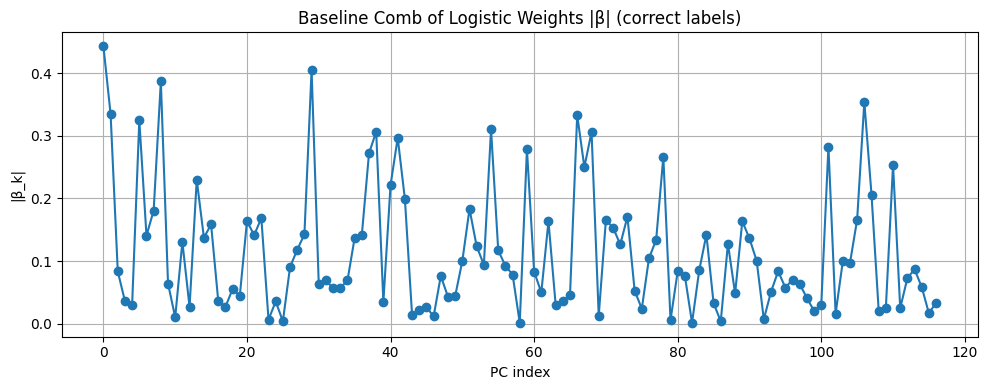

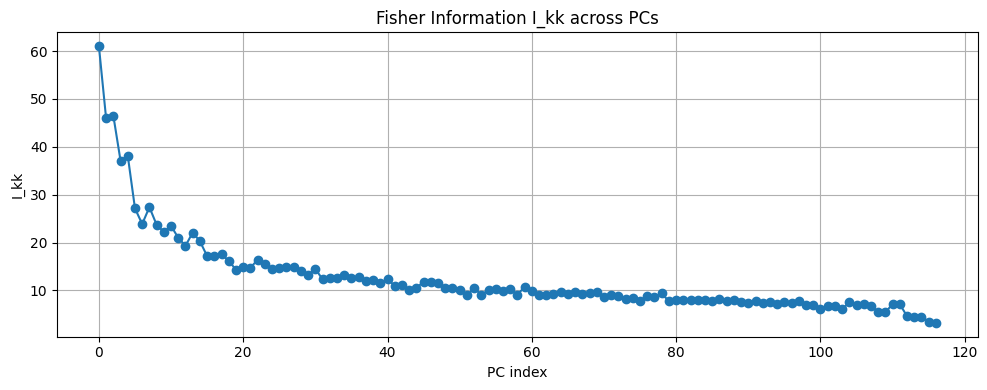

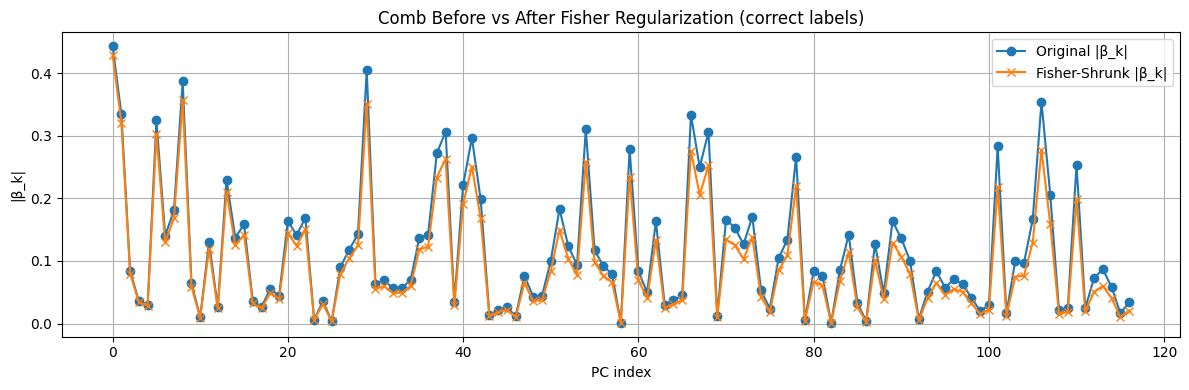

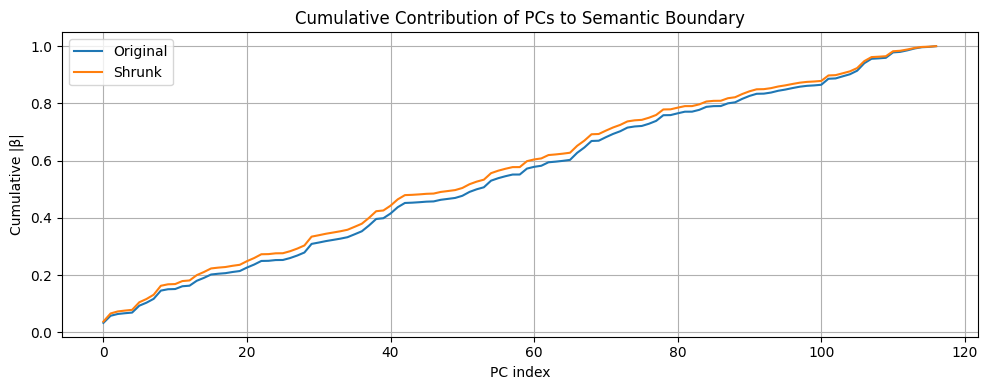

In [ ]:
#https://chatgpt.com/c/6935dd2e-0820-8330-b048-06d71c27768a

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 0. Paths (from your message)
# ---------------------------------------------------------

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # dict or array depending on your file
R     = np.load(NEURAL_PATH)                                  # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)                  # (neurons,)

print("R shape (images, neurons):", R.shape)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ============================================================
# 1) LOAD YOUR DATA (already in workspace)
# R: neurons × images  → X: images × neurons
# vit: (images × classes)
# ============================================================

X = R.T.astype(float)   # (118 images, ~39k neurons)
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)

print("X:", X.shape, "y mean:", y.mean())

# ============================================================
# 2) PCA on neural responses
# ============================================================

pca_dim = 117
pca = PCA(n_components=pca_dim, svd_solver="randomized")
Z = pca.fit_transform(X)     # (118 × pca_dim)

variances = pca.explained_variance_

print("Neural PCs:", Z.shape)

# ============================================================
# 3) Logistic regression in PC space (baseline comb)
# ============================================================

clf = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='liblinear',
    max_iter=500
)

clf.fit(Z, y)
beta = clf.coef_.ravel()
b0 = clf.intercept_[0]

# Plot baseline comb
plt.figure(figsize=(10,4))
plt.plot(np.abs(beta), marker='o')
plt.title("Baseline Comb of Logistic Weights |β| (correct labels)")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 4) Fisher information for logistic regression
# ============================================================

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

g = Z @ beta + b0
p = sigmoid(g)
w_diag = p * (1 - p)         # N × 1

# Fisher matrix: F = Z^T diag(w) Z
F = (Z.T * w_diag) @ Z
fisher_diag = np.diag(F) + 1e-12   # avoid divide-by-zero

plt.figure(figsize=(10,4))
plt.plot(fisher_diag, marker='o')
plt.title("Fisher Information I_kk across PCs")
plt.xlabel("PC index")
plt.ylabel("I_kk")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 5) Fisher-weighted shrinkage
# ============================================================

lambda_reg = 2.0      # you can sweep this later

beta_shrunk = beta / (1 + lambda_reg / fisher_diag)

# ============================================================
# 6) COMPARE combs: baseline vs Fisher-regularized
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(np.abs(beta), label="Original |β_k|", marker='o')
plt.plot(np.abs(beta_shrunk), label="Fisher-Shrunk |β_k|", marker='x')
plt.title("Comb Before vs After Fisher Regularization (correct labels)")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 7) Cumulative contribution to the decision boundary
# ============================================================

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(np.abs(beta)) / np.sum(np.abs(beta)), label="Original")
plt.plot(np.cumsum(np.abs(beta_shrunk)) / np.sum(np.abs(beta_shrunk)), label="Shrunk")
plt.title("Cumulative Contribution of PCs to Semantic Boundary")
plt.xlabel("PC index")
plt.ylabel("Cumulative |β|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
